In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from PIL import Image


In [2]:
# Function to compute gradient of an image
def compute_gradient(u):
    """
    Compute the gradient of image u along x and y axes.
    """
    u_x = np.gradient(u, axis=1)  # Gradient along x-axis
    u_y = np.gradient(u, axis=0)  # Gradient along y-axis
    return u_x, u_y


In [3]:
# Function to compute magnitude of gradient
def compute_magnitude(u_x, u_y):
    """
    Compute the magnitude of the gradient.
    """
    mag = np.sqrt(u_x**2 + u_y**2) + 1e-8  # Add epsilon to avoid division by zero
    return mag


In [4]:
# Function to compute divergence of a vector field
def compute_divergence(p, q):
    """
    Compute the divergence of a vector field (p, q).
    """
    p_x = np.gradient(p, axis=1)  # Partial derivative of p with respect to x
    q_y = np.gradient(q, axis=0)  # Partial derivative of q with respect to y
    div = p_x + q_y
    return div


In [5]:
# Function to compute gradient of the energy function
def compute_energy_gradient(u, f, lam):
    """
    Compute the gradient of the energy function E(u).
    """
    # Data fidelity term gradient
    data_grad = -2 * lam * (f - u)
    
    # Regularization term gradient
    u_x, u_y = compute_gradient(u)
    mag = compute_magnitude(u_x, u_y)
    u_x_norm = u_x / mag
    u_y_norm = u_y / mag
    div = compute_divergence(u_x_norm, u_y_norm)
    reg_grad = -div
    
    # Total gradient
    grad = data_grad + reg_grad
    return grad


In [6]:
# Function to compute the energy function E(u)
def compute_energy(u, f, lam):
    """
    Compute the energy function E(u).
    """
    # Data fidelity term
    data_fidelity = lam * np.sum((f - u)**2)
    # Regularization term
    u_x, u_y = compute_gradient(u)
    mag = compute_magnitude(u_x, u_y)
    regularization = np.sum(mag)
    # Total energy
    E = data_fidelity + regularization
    return E


In [7]:
# Gradient descent algorithm for total variation denoising
def tv_denoising(f, lam, alpha, max_iter=200, tol=1e-5):
    """
    Perform total variation denoising using gradient descent.
    """
    # Initialize u with the noisy image
    u = f.copy()
    energy_values = []
    for k in range(max_iter):
        # Compute gradient of the energy function
        gradE = compute_energy_gradient(u, f, lam)
        # Update u
        u = u - alpha * gradE
        # Clip u to maintain valid image pixel range
        u = np.clip(u, 0, 1)
        # Compute energy and store it for convergence plot
        E = compute_energy(u, f, lam)
        energy_values.append(E)
        # Check for convergence
        if k > 0 and abs(energy_values[k] - energy_values[k-1]) < tol:
            print(f'Converged at iteration {k}')
            break
    return u, energy_values


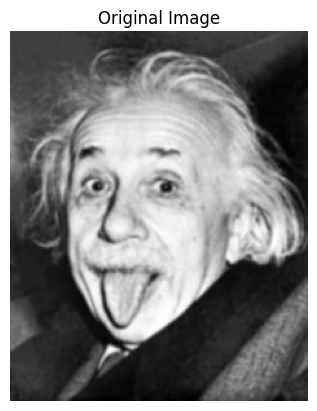

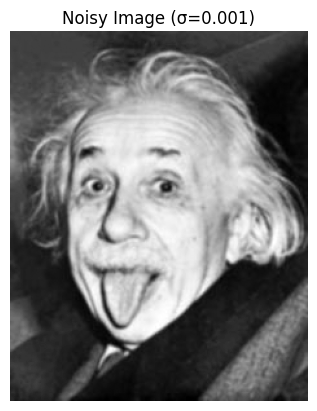

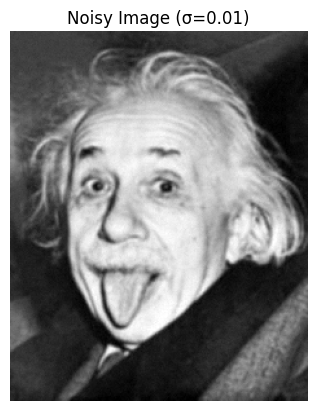

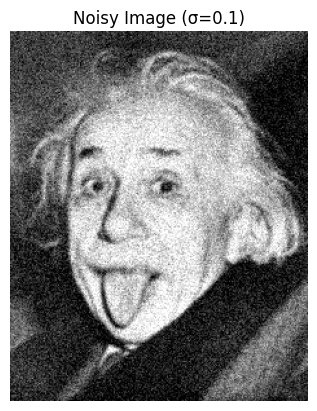

Denoising image with σ=0.001


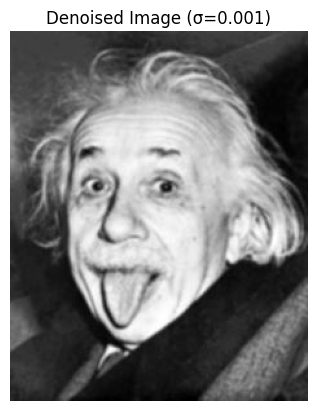

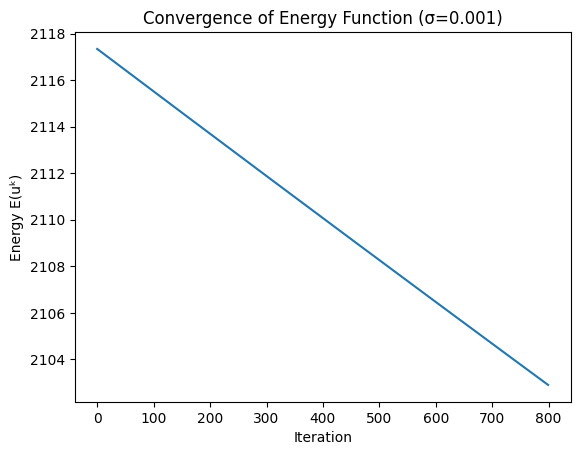

Denoising image with σ=0.01


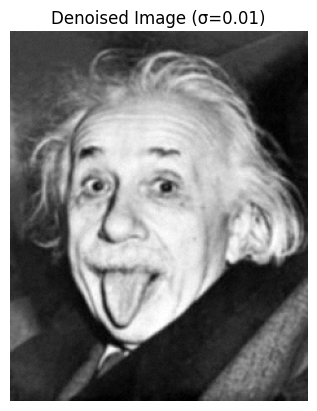

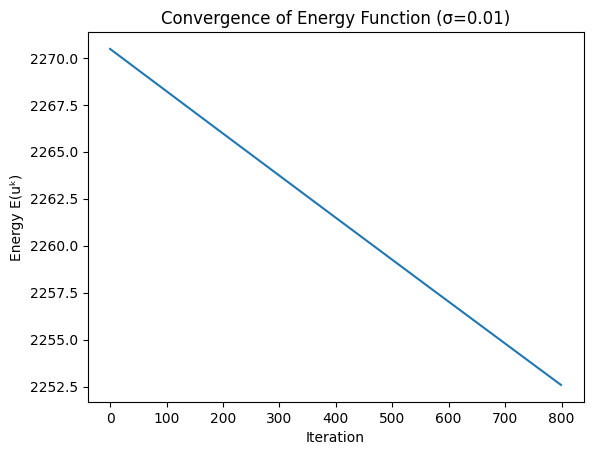

Denoising image with σ=0.1


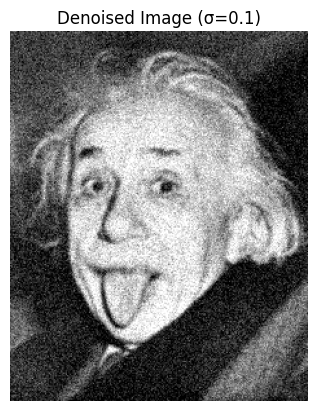

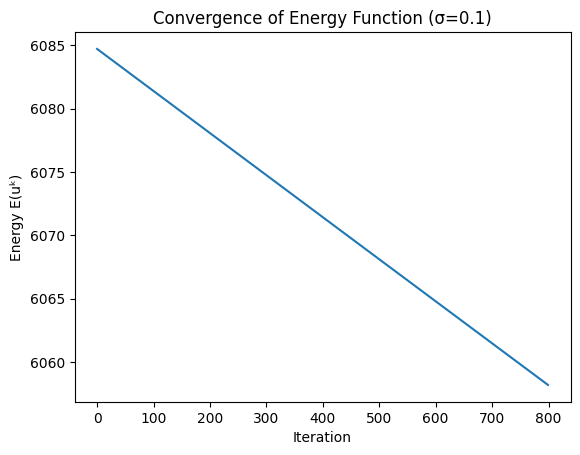

In [8]:
# Read and normalize the image
img = cv2.imread('Einstein.jpeg', cv2.IMREAD_GRAYSCALE)
img = img.astype(np.float64) / 255.0  # Normalize to [0,1]

# Display the original image
plt.figure()
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

# Generate noisy images with additive Gaussian noise
noise_variances = [0.001, 0.01, 0.1]
noisy_images = []

for sigma in noise_variances:
    # Generate Gaussian noise
    noise = np.random.normal(0, sigma, img.shape)
    # Add noise to the original image
    noisy_img = img + noise
    # Clip to maintain valid pixel range
    noisy_img = np.clip(noisy_img, 0, 1)
    noisy_images.append(noisy_img)
    # Display the noisy image
    plt.figure()
    plt.imshow(noisy_img, cmap='gray')
    plt.title(f'Noisy Image (σ={sigma})')
    plt.axis('off')
    plt.show()

# Parameters for denoising
lam = 0.000001     # Regularization parameter λ
alpha = 0.0000005  # Step size α
max_iter = 800     # Maximum number of iterations
tol = 1e-5         # Tolerance for convergence

# Denoise each noisy image and display results
for i, noisy_img in enumerate(noisy_images):
    sigma = noise_variances[i]
    print(f'Denoising image with σ={sigma}')
    # Perform total variation denoising
    denoised_img, energy_values = tv_denoising(noisy_img, lam, alpha, max_iter, tol)
    
    # Display the denoised image
    plt.figure()
    plt.imshow(denoised_img, cmap='gray')
    plt.title(f'Denoised Image (σ={sigma})')
    plt.axis('off')
    plt.show()
    
    # Plot convergence graph of the energy function
    plt.figure()
    plt.plot(energy_values)
    plt.title(f'Convergence of Energy Function (σ={sigma})')
    plt.xlabel('Iteration')
    plt.ylabel('Energy E(uᵏ)')
    plt.show()
